# Are you making money?  

In our daily activities, we have different things that we have to do, and amongst them is paying for rent and utility bills, Netflix subscription, buying groceries, and several other types of transactions. Of course, we keep the receipts from most of the transactions and from time to time we go back to check the balance sheet prepared by out banks. But most of the time banks don't offer any rigorous seasonal analysis which can help us understand whether we are gaining or loosing money on a global scale. They simply give you the values of the transactions or when you get your salary or someone transfers money to you. 

In this script, you will get a set of visualizations which will help you understand how you spending are periodically, and it can help you make better life decisions.

Enjoy!

PS: In the script there is a section where I discuss how to handle external cash as well ... so keep reading ;) 

### 1 - Import functions 

In [1]:
#Impoorting required functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import datetime as dt
from scipy.signal import savgol_filter as SF


The *SF* is the Savitzky-Golay filter, which  is a nice smoothing algorithm which we will use. For the mathematical details, check  https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

### 2 - Import your data 

I have set in this repository a randomly generated transaction list, where the person has a salary of 20000(assume any currency) and pays a monthly of 1500 for rent. 

To keep the approach simple, I did not generate random transaction time only dates. 

In [39]:
#The file you get from your bank or app
data_comp = pd.read_csv("expenses.csv")

data_comp

,date,trans
0,2020-11-26,18000.0
1,2020-11-26,-120.0
2,2020-11-27,-500.0
3,2020-11-30,-18.0
4,2020-11-30,-44.0
...,...,...
332,2021-05-16,-312.1
333,2021-05-17,-126.3
334,2021-05-18,-243.7
335,2021-05-19,-125.2


<AxesSubplot:>

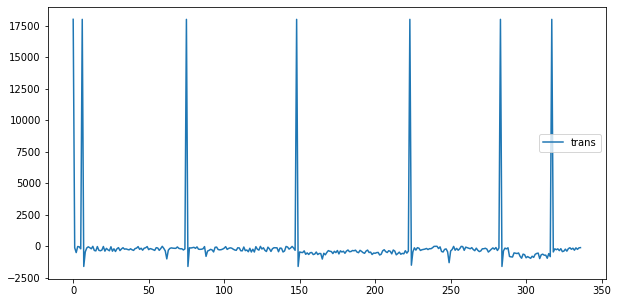

In [40]:
data_comp.plot(figsize=(10,5))


### 3 - Pre-Processing

We can see that we can have several transactions on a specific specific day, so it is important to aggregate them based on a specific period. 

Let's clean it up a little, where we will convert the dates into timestamps, and sort them. Originally they are simply objects. 

In [38]:
print(data_comp.dtypes)

date      object
trans    float64
dtype: object


Now Let's convert the date column into pandas timestamps

In [4]:
data_comp.date=pd.to_datetime(data_comp.date)
data_comp.dtypes

date     datetime64[ns]
trans           float64
dtype: object

It's also very important to aggregate the transactions based on a period. In our case we will aggregate them based on the available dates.

In [5]:
data_comp.sort_values(by=['date'],inplace=True)
data_daily = data_comp.groupby("date").agg({'trans':'sum'})


The user can select a different set of periods for aggregation and periodic distribution. Here I will choose for it to be daily. Pandas offers the options of generating dates based on letters to get to know the options, check this website.   https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases

In [6]:
periodicity  = 'D' 

In [7]:
date_r = pd.date_range(start = data_daily.index[0],
                       end = data_daily.index[-1],
                       freq = periodicity)

data = data_daily.reindex(date_r,fill_value=0)
data

,trans
2020-11-26,17880.0
2020-11-27,-500.0
2020-11-28,0.0
2020-11-29,0.0
2020-11-30,-262.0
...,...
2021-05-16,-312.1
2021-05-17,-126.3
2021-05-18,-243.7
2021-05-19,-125.2


In [8]:
data = data_comp.groupby("date").agg({'trans':'sum'})
data.index = list(data.index)

Let's assume that you had an old bank account and before you arrived to a new country, you pulled out the remaining of your cash from that bank account and took advantage of the market's currency exchange rate and not paying the transfer fees for payments. To include that in your new transactions, you can simply distributed evenly on you periodic transactions after checking what remained. This can be also assumed as you starting seed money for your new life :D ...  

In [9]:
#cash    
current =  5000 #The most recent available cash
max_budge = 7000 #The original amount
external = max_budge - current  
external = external / (len(data) - 1)
external = len(data)*[-external ]

#Add it 
#total money
data['external'] = external
data['trans_total'] = data.trans + data.external
data

,trans,external,trans_total
2020-11-26,17880.0,-12.738854,17867.261146
2020-11-27,-500.0,-12.738854,-512.738854
2020-11-30,-262.0,-12.738854,-274.738854
2020-12-01,16400.0,-12.738854,16387.261146
2020-12-02,-617.0,-12.738854,-629.738854
...,...,...,...
2021-05-16,-312.1,-12.738854,-324.838854
2021-05-17,-126.3,-12.738854,-139.038854
2021-05-18,-243.7,-12.738854,-256.438854
2021-05-19,-125.2,-12.738854,-137.938854


### 4 - Crunching the numbers 

Now we will do some calculations to check how much you have earned and spent ... In other words, we'll check the profit. Basically, are you spending more than you should or are you saving money? 

Here you should be careful ... There are some calculations to be done. There are 3 main essential values to be calculated: 

1. ***CS***: The cumulative sum of transactions
2. ***RM***: The remainder, or how much money you had plus the cumulative transactions, and this tells you about what's happening
3. ***PPC***: Periodic percentage change in your remainder

    $\large PPC_{i} = \Large\frac{RM_{i}-RM_{i-1}}{RM_{i-1}}$ = $\Large\frac{RM_{i}}{RM_{i-1}}$ $\large-1$ 

In [10]:
#analysis
data['CS'] = data.trans_total.cumsum()
data['RM'] = data.CS + max_budge 
data['PPC'] = [np.nan]+ [(data.RM.iloc[i]/data.RM.iloc[i-1]) -1   for i in range(1,len(data))]

data



,trans,external,trans_total,CS,RM,PPC
2020-11-26,17880.0,-12.738854,17867.261146,17867.261146,24867.261146,NaN
2020-11-27,-500.0,-12.738854,-512.738854,17354.522293,24354.522293,-0.020619
2020-11-30,-262.0,-12.738854,-274.738854,17079.783439,24079.783439,-0.011281
2020-12-01,16400.0,-12.738854,16387.261146,33467.044586,40467.044586,0.680540
2020-12-02,-617.0,-12.738854,-629.738854,32837.305732,39837.305732,-0.015562
...,...,...,...,...,...,...
2021-05-16,-312.1,-12.738854,-324.838854,9805.516561,16805.516561,-0.018963
2021-05-17,-126.3,-12.738854,-139.038854,9666.477707,16666.477707,-0.008273
2021-05-18,-243.7,-12.738854,-256.438854,9410.038854,16410.038854,-0.015387
2021-05-19,-125.2,-12.738854,-137.938854,9272.100000,16272.100000,-0.008406


### 5 - Creating summaries 

#### Explorartory 

Lets start by visualizing the actual transactions, we will also calculate the mean, maximum, and the smoothed average using the the Savitzky-Golay filter on a monthly basis of 31 days (this filter requires the duration to be always odd). 

In [29]:
smooth_dur = 61 

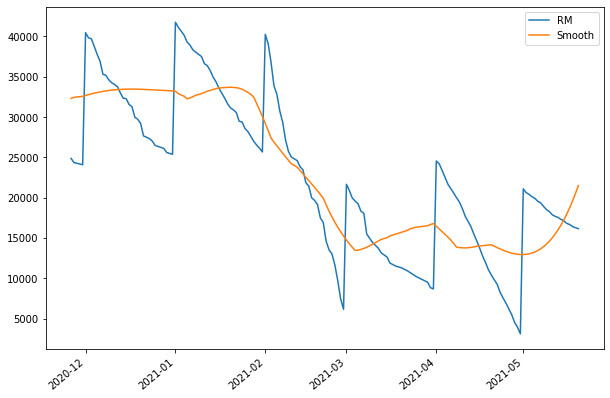

In [30]:
#apply filter and and smooth
data['Smooth'] = SF(data.RM,window_length=smooth_dur,polyorder=3)
data['Maximum'] = data.shape[0]*[data.RM.max()]
data['Mean'] = data.shape[0]*[data.RM.mean()]


#ploting
data[['RM','Smooth']].plot(figsize=(10,7))
plt.legend()
plt.xticks(rotation=40)
plt.show()






Let's also check about how we are spending based on weekday

It seems this guy is a Monday spender :D

#### Monthly report

Now that we have the building blocks of our daily expenses, we can do an analysis for our periodic results. 

One way of doing that is to calculate the coefficient of variation or the relative standard deviation of the PPC. It gives you a nice idea about how much you about the gain and the loses on average, and tells you how dispersed they are with respect to other months. Check this video. 

https://www.youtube.com/watch?v=9dwLKGoaeEs&ab_channel=zedstatistics

But in fact I'll be using it's inverse to have 

RSD = $\Large\frac{\sigma}{\mu}$  

To have a better idea of it usefulness regarding your monthly expenses, I want to calculate it from the beginning of each month.

In [33]:
periods = 'MS' #with pandas this activates 1st of months
date_r = pd.date_range(start=data.index[0],end=data.index[-1],freq=periods)
date_r

DatetimeIndex(['2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01'],
              dtype='datetime64[ns]', freq='MS')

period 0: [2020-12-01, 2021-01-01] = 27 --> RSD = 18.34106899442672
period 1: [2021-01-01, 2021-02-01] = 28 --> RSD = 35.15998401812905
period 2: [2021-02-01, 2021-03-01] = 27 --> RSD = 17.639368712115324
period 3: [2021-03-01, 2021-04-01] = 23 --> RSD = 9.323901576174544
period 4: [2021-04-01, 2021-05-01] = 30 --> RSD = 8.245533432335588


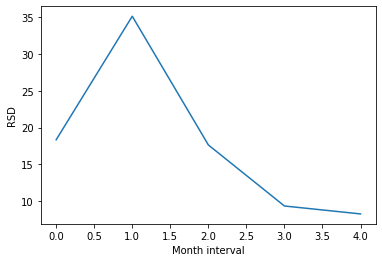

In [34]:
#calculate IRSDs
RSD=[]
for id,idx in enumerate(range(1,len(date_r))):
    temp = data[(data.index<=date_r[idx]) & (data.index>date_r[idx-1])]
    mean = np.nanmean(temp.PPC)
    std = np.nanstd(temp.PPC)
    rsd = std/mean 
    print(f"period {id}: [{date_r[idx-1].date()}, {date_r[idx].date()}] = {temp.shape[0]} --> RSD = {rsd}")
    RSD.append(rsd)

    
plt.plot(RSD)
plt.ylabel("RSD")
plt.xlabel("Month interval")
plt.show()



#### Weekly analysis

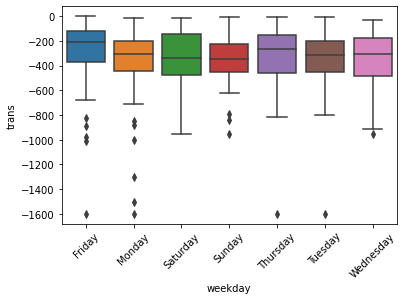

In [35]:
#encode days
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#check for expenses on weekly
data_comp['weekday'] = [ dt.datetime.strftime(x, '%A') for x in data_comp.date]
data_week = data_comp.query("trans<0").sort_values(by='weekday')

ax=seaborn.boxplot(y="trans",x="weekday", data=data_week)
plt.xticks(rotation=45)
plt.show()

# Conclusions

We can see that this simulated sample above shows that the spending behavior is the highest regarding outliers during Mondays. This person's spending behaviour is deteriorating as the months go by and should start thinking about cutting there expenses 